In [1]:
import torch
from pathlib import Path


from model_architectures import MonaiDDPM
device = "cuda:0" if torch.cuda.is_available() else "cpu"


CONDITIONAL = True
RESOLUTION = 256
T = 1_000     

root = Path("/home/locolinux2/U24_synthesis/lightning_synthesis/experiments")
# ckpt  = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/049_cDDPM_depth5_fixedScaling_256x256/checkpoints/epoch=22-step=7843.ckpt" # FID = 8.18 at guidance scale 3
ckpt  = "053_DDPM__DataArtifactsRemoved___256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt  = "054_DDPM_default512_256x256/checkpoints/epoch=04-step=1435.ckpt" # FID @ GS 0: 7.38
ckpt  = "057_DDPM_seed2025_cropped_256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt = "063_DDPM_contrast-aug-20percent_256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt = "092_DDPM_MS-SSIM_10perc_HF_5perc_256x256/checkpoints/epoch=18-step=2736.ckpt" # GOLD
# ckpt = "106_DDPM_3loss_binary_try/checkpoints/epoch=18-step=2736.ckpt" # functional binary
ckpt = "107_DDPM_3loss_4class_retry/checkpoints/epoch=17-step=3456.ckpt"
ckpt = "113_DDPM_binary_epochwise_balanced/checkpoints/epoch=30-step=1116.ckpt" # dynamic epoch-wise data balancing 
ckpt = "114_DDPM_binary_epochwise_balanced_12vs56/checkpoints/epoch=22-step=1771.ckpt" # more data
ckpt = "121_DDPM_binary_21fixedmatching_12vs56/checkpoints/epoch=20-step=1827.ckpt" #  just to check how epoch-wise sampling affects things
ckpt = "120_DDPM_binary_21perepoch_12vs56/checkpoints/epoch=19-step=1740.ckpt" # seems decent! Even guidance scale 4 gets 70% accuracy.
ckpt = "123_DDPM_binary_11_5perepoch_12vs56/checkpoints/epoch=20-step=1512.ckpt" # 
ckpt = "124_DDPM_binary_11perepoch_12vs56/checkpoints/epoch=26-step=1566.ckpt"
# ckpt = "140_DDPM_augmentationsgeometric_binary_11perepoch_12vs56/checkpoints/epoch=26-step=1566.ckpt" # let's see augmentations doin stuff

ckpt_path = root /ckpt 
model = MonaiDDPM.load_from_checkpoint(
    ckpt_path
).to(device).eval()

Error importing huggingface_hub.file_download: 'Version'


/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Loss function using 0.85 MSE and 0.1 similarity measure MultiScaleStructuralSimilarityIndexMeasure(), and 0.050000000000000044 high frequency
Initialized conditional model.


In [2]:
# %load_ext tensorboard
# %tensorboard --logdir logs/ --port 6007

In [ ]:
import torch, random, glob, os, nibabel as nib
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt

# ── paths ───────────────────────────────────────────────────────────
ROOT_REAL = "/mnt/d/Datasets/EMBED/EMBED_binary_256x256/train/original"
if "CMMD" in ckpt:
    ROOT_REAL = "/mnt/d/Datasets/CMMD/CMMD_binary_256x256/train/original"

LABELS       = {0: "benign", 1: "malignant"}
GUIDE_SCALES = [0, 4, 8]
N_PER_CLASS  = 4
RESOLUTION   = 256
device       = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------------
# helper: load NIfTI slice → 1-channel PIL image
def load_nii_as_pil(path):
    arr = nib.load(path).get_fdata().astype(np.float32)
    if arr.ndim == 3:         # (H,W,1) or (H,W,D) keep first slice
        arr = arr[..., 0]
    # min-max normalise to 0-255 for PIL
    arr = (255 * (arr - arr.min()) / (arr.ptp() + 1e-8)).astype(np.uint8)
    return Image.fromarray(arr, mode="L")

# torchvision transform
to_tensor = transforms.Compose([
    transforms.ToTensor(),                 # → [0,1]
    transforms.Normalize(0.5, 0.5),        # → [-1,1]
])

# ── 0.  real rows ───────────────────────────────────────────────────
real_rows = []
for lbl, folder in LABELS.items():
    nii_paths = glob.glob(
        os.path.join(ROOT_REAL, folder, "*", "slice.nii.gz")
    )
    if len(nii_paths) < N_PER_CLASS:
        raise RuntimeError(f"Need {N_PER_CLASS} slices in {folder}")
    picks = random.sample(nii_paths, N_PER_CLASS)

    tensors = []
    for p in picks:
        img = to_tensor(load_nii_as_pil(p))   # (1,H,W) in [-1,1]
        tensors.append((img + 1) / 2)         # back → [0,1] for display
    real_rows.append(torch.stack(tensors))
real_row = torch.cat(real_rows, 0)            # (8,1,H,W)

# ── 1.  fake rows (guidance 0 & 8) ─────────────────────────────────-
fake_rows = []
with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
    for gs in GUIDE_SCALES:
        per_label = []
        for lbl in LABELS:
            per_label.append(
                model.sample(N=N_PER_CLASS, label=lbl,
                             size=RESOLUTION, guidance_scale=gs).cpu()
            )
        fake_rows.append(torch.cat(per_label, 0))   # (8,1,H,W)




 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 729/1000 [01:55<00:42,  6.38it/s]

In [ ]:
# ── 2.  stack & plot  ──────────────────────────────────────────────
rows = [real_row] + fake_rows                                    # 3 tensors
all_imgs = torch.cat(rows, 0)                                    # (24,1,H,W)

# grid: 8 images per row   (2 labels * 4 each)
grid = make_grid(
    all_imgs,
    nrow=len(LABELS) * N_PER_CLASS,      # 8 columns
    padding=2,
    value_range=(0, 1),
)

grid_img = grid.permute(1, 2, 0).cpu().numpy()   # (H,W,1)

# ── Add horizontal white bars ------------------------------------------------
row_height = RESOLUTION + 2                       # image + padding*2
for r in [1, 2]:                                  # after first & second rows
    y = r * row_height + 1                        # +1 to hit padding zone
    grid_img[y:y + 4, :, :] = 1.0                 # 4-px white bar

# ── Plot with row labels ------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
ax.imshow(grid_img, cmap="gray")
ax.axis("off")

labels_right = ["real", "guid=0", "guid=8"]
for idx, txt in enumerate(labels_right):
    y_center = idx * row_height + row_height // 2
    ax.text(
        grid_img.shape[1] + 10,          # a few px to the right
        y_center,
        txt,
        va="center",
        fontsize=12,
        color="black",
    )

fname = f"comparison_grid-{ckpt[:15]}.pdf"
plt.savefig(fname, bbox_inches="tight")
plt.show()
print(f"Saved grid → {fname}")


In [2]:
dd = {}
# GUIDE_SCALES = [5] 
labels = [0,1]
for ll in labels:
    nb_images = 8
    with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
        samples = model.sample(
            N=nb_images,
            label=ll,
            size=RESOLUTION,
            guidance_scale=5
        )
    dd[ll]=samples
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:26<00:00,  1.41s/it]


In [3]:
for img in samples:
    print(samples.max(), samples.min())

tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')


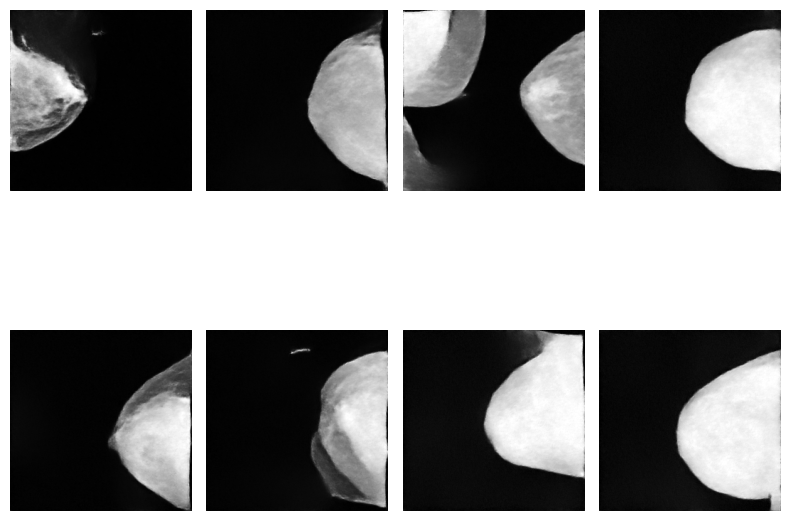

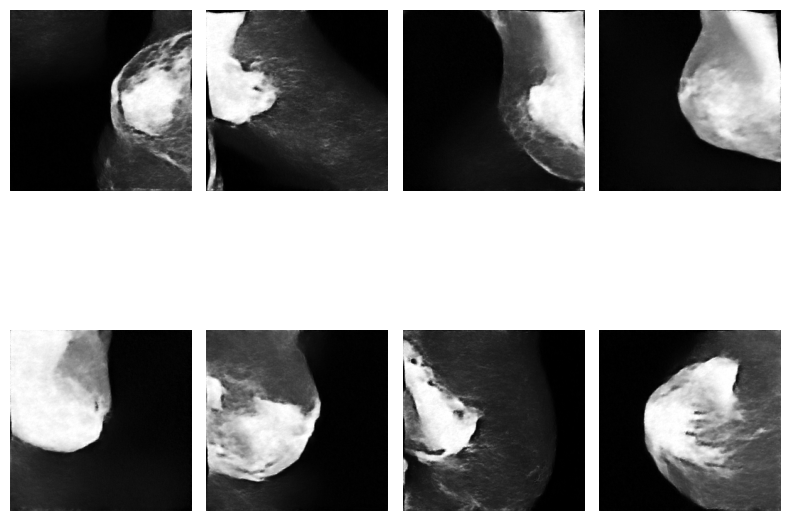

In [4]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in labels:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()


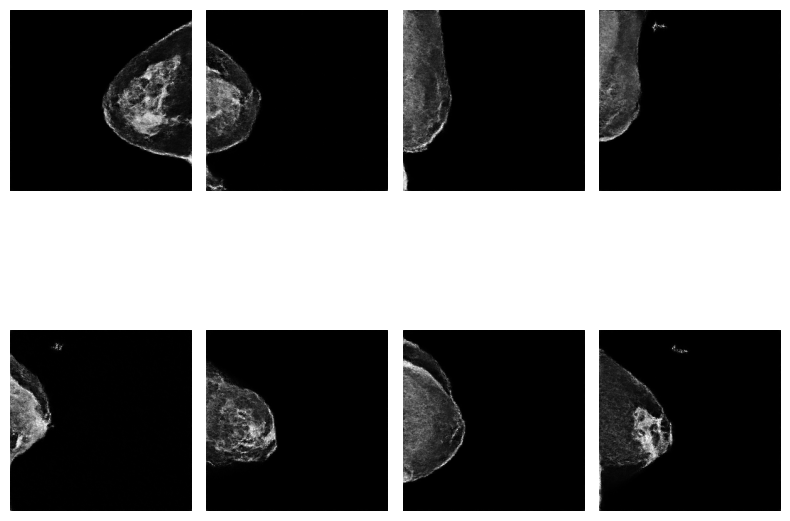

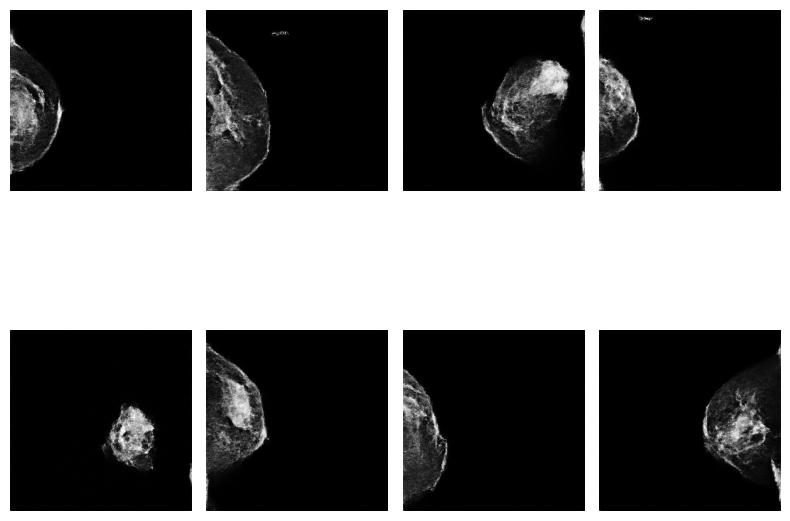

In [4]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in labels:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()


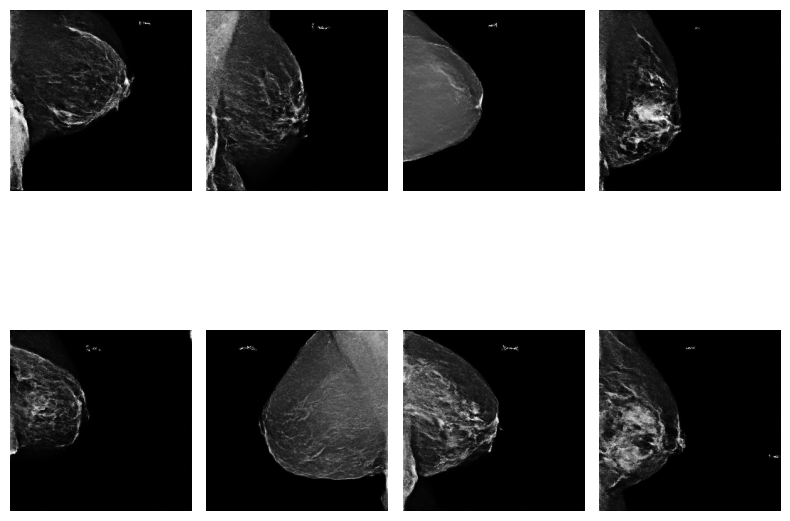

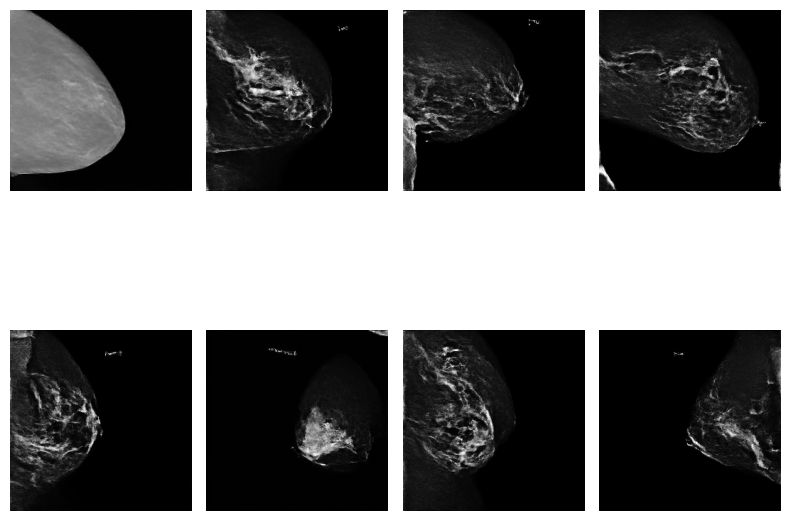

In [7]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in labels:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()

# else:
#     plt.style.use("default")
#     plt.imshow(chain[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
#     plt.axis("off")
#     plt.tight_layout()

#     plt.show()


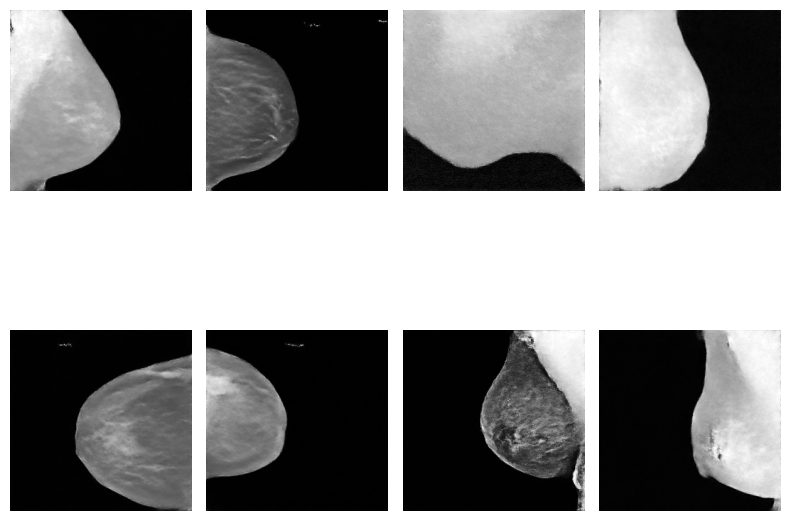

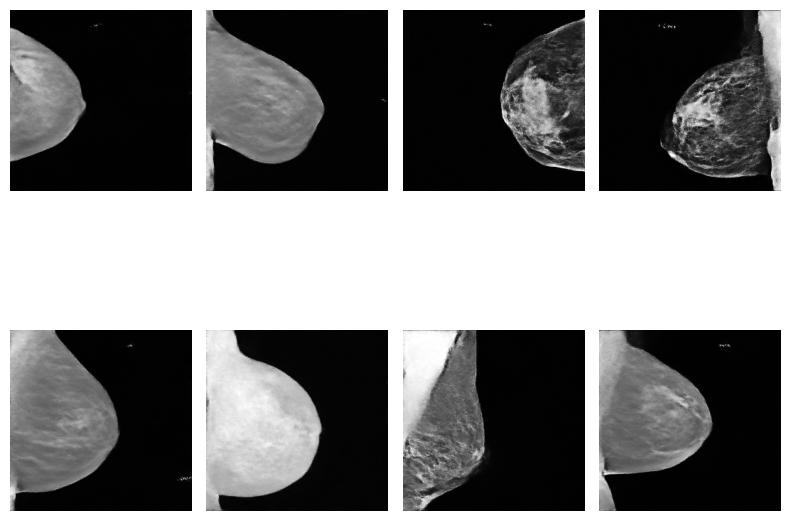

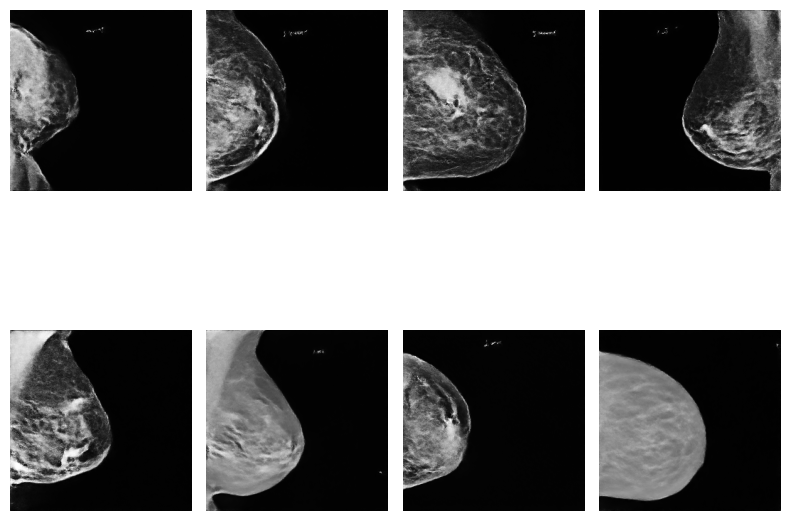

In [5]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in GUIDE_SCALES:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()

# else:
#     plt.style.use("default")
#     plt.imshow(chain[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
#     plt.axis("off")
#     plt.tight_layout()

#     plt.show()


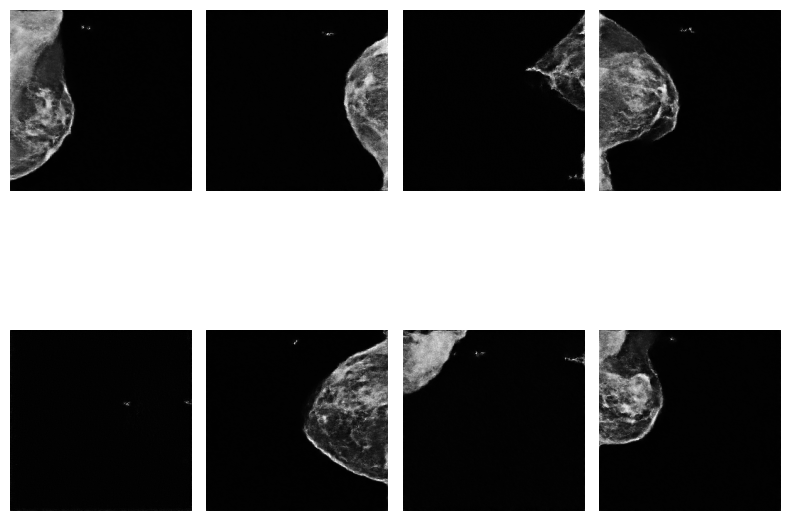

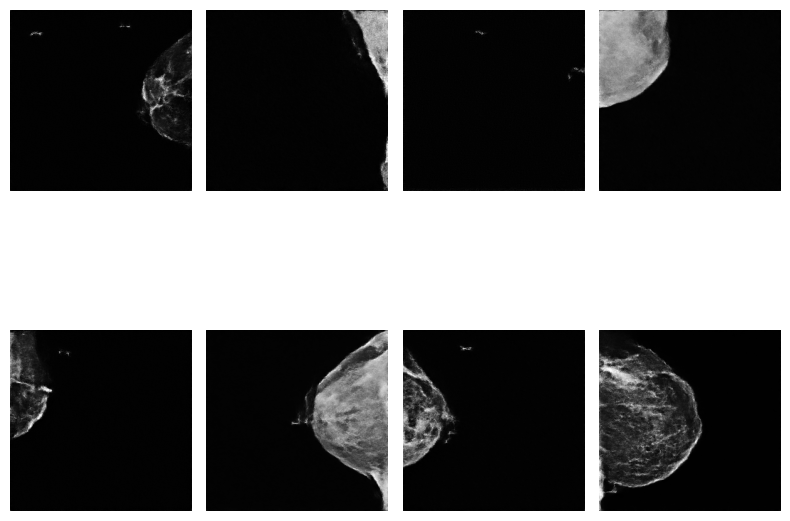

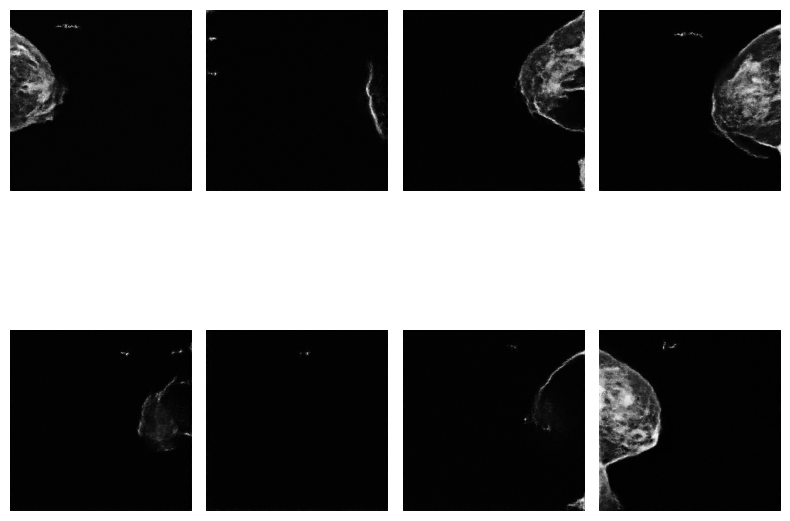

In [12]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in GUIDE_SCALES:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()

# else:
#     plt.style.use("default")
#     plt.imshow(chain[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
#     plt.axis("off")
#     plt.tight_layout()

#     plt.show()


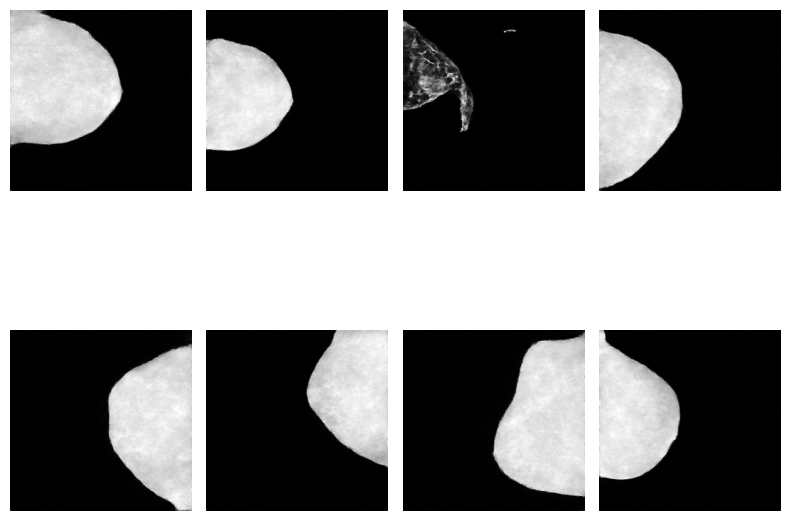

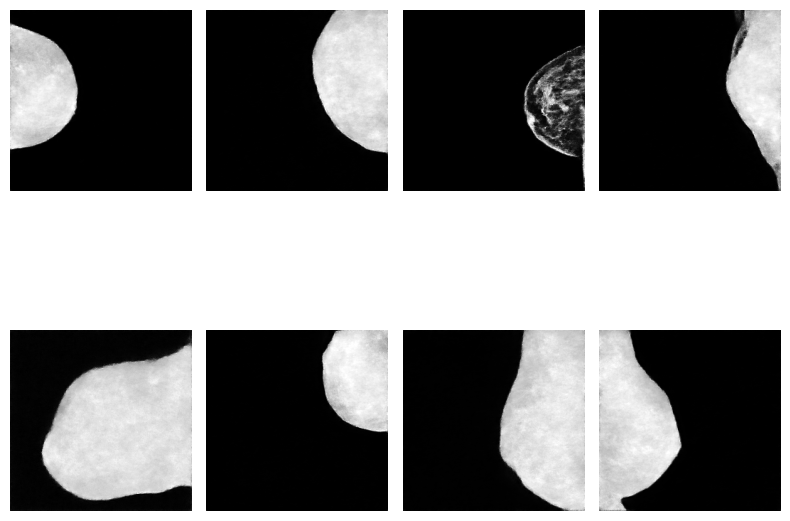

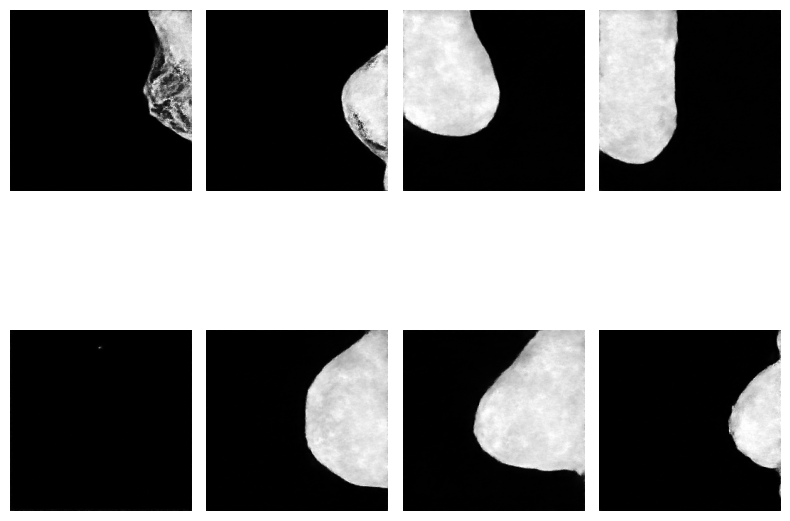

In [6]:
import matplotlib.pyplot as plt

# if CONDITIONAL:
for v in GUIDE_SCALES:
    vis_samples = dd[v]
    plt.figure(figsize=(8, 8))           
    for i in range(8):                   # ⟵ only 8 images
        plt.subplot(2, 4, i + 1)         # 2 × 2 grid
        plt.axis("off")
        plt.imshow(vis_samples[i, 0].cpu(), cmap="gray", vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig("./inference_snapshots/samples_grid.png", dpi=300)
    plt.show()

# else:
#     plt.style.use("default")
#     plt.imshow(chain[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
#     plt.axis("off")
#     plt.tight_layout()

#     plt.show()
